In [141]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix, classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import math


## Load the data and train the model

In [70]:
# loads data
eye_data = pd.read_csv("eye_data_set.csv")

# clean column titles
eye_data.columns = [col.lower() for col in eye_data]
eye_data.columns = [col.replace('-','_').replace(' ','_') for col in eye_data]

# Drop unnecessary rows
cleaned_eye_data = eye_data.drop(columns=['id','left_fundus', 'right_fundus','filepath','filename'])

# View data sets 
#eye_data.head(1)
cleaned_eye_data.head(1)

,patient_age,patient_sex,left_diagnostic_keywords,right_diagnostic_keywords,n,d,g,c,a,h,m,o,labels,target
0,69,Female,cataract,normal fundus,0,0,0,1,0,0,0,0,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]"


In [71]:
# view the structure of the data
cleaned_eye_data.info()

# scikit-learn can not handle columns with type object so we will need to transform them with the process of 1 hot encoding

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   patient_age                6392 non-null   int64 
 1   patient_sex                6392 non-null   object
 2   left_diagnostic_keywords   6392 non-null   object
 3   right_diagnostic_keywords  6392 non-null   object
 4   n                          6392 non-null   int64 
 5   d                          6392 non-null   int64 
 6   g                          6392 non-null   int64 
 7   c                          6392 non-null   int64 
 8   a                          6392 non-null   int64 
 9   h                          6392 non-null   int64 
 10  m                          6392 non-null   int64 
 11  o                          6392 non-null   int64 
 12  labels                     6392 non-null   object
 13  target                     6392 non-null   object
dtypes: int64

In [72]:
# split the numerical value
num_cols = pd.DataFrame(cleaned_eye_data[cleaned_eye_data.select_dtypes(include=['int']).columns])

num_cols.head(1)

,patient_age,n,d,g,c,a,h,m,o
0,69,0,0,0,1,0,0,0,0


In [73]:
# check the Cardinality of the categorical values
cat_cols = pd.DataFrame(cleaned_eye_data[cleaned_eye_data.select_dtypes(include=['object']).columns])
# counts the unique values
unique_values = cat_cols.nunique()
print(f'size of the dataset {cleaned_eye_data.size}')
print(unique_values)


# There is moderate to high cardinality  with the L and R keywords
# left_diagnostic keywords     196
# right_diagnostic keywords    205

# To prevent overfitting and impact the random forest model

size of the dataset 89488
patient_sex                    2
left_diagnostic_keywords     196
right_diagnostic_keywords    205
labels                         8
target                         8
dtype: int64


In [74]:
# check the value of the data 
left_values = pd.DataFrame(cleaned_eye_data['left_diagnostic_keywords'].value_counts()).T
left_values

left_diagnostic_keywords,normal fundus,moderate non proliferative retinopathy,mild nonproliferative retinopathy,cataract,pathological myopia,glaucoma,dry age-related macular degeneration,severe nonproliferative retinopathy,drusen,epiretinal membrane,...,silicone oil eye,optic disc edema,spotted membranous change，spotted membranous change,image offset,old central retinal vein occlusion,fundus laser photocoagulation spots,retinal pigment epithelium atrophy，diabetic retinopathy,white vessel，suspected glaucoma,lens dust，glaucoma,glaucoma，wet age-related macular degeneration
count,2796,717,428,268,208,207,184,139,130,106,...,1,1,1,1,1,1,1,1,1,1


In [75]:
# check the value of the data 
right_values = pd.DataFrame(cleaned_eye_data['right_diagnostic_keywords'].value_counts()).T
right_values

right_diagnostic_keywords,normal fundus,moderate non proliferative retinopathy,mild nonproliferative retinopathy,cataract,pathological myopia,dry age-related macular degeneration,glaucoma,severe nonproliferative retinopathy,macular epiretinal membrane,drusen,...,chorioretinal atrophy，epiretinal membrane,congenital choroidal coloboma,atrophy,white vessel，moderate non proliferative retinopathy,laser spot，mild nonproliferative retinopathy,retinochoroidal coloboma，epiretinal membrane,vitreous degeneration，lens dust,retinal pigment epithelial hypertrophy，moderate non proliferative retinopathy,optic disc edema,macular epiretinal membrane，laser spot，lens dust，mild nonproliferative retinopathy
count,2705,745,472,250,216,204,190,147,141,140,...,1,1,1,1,1,1,1,1,1,1


In [76]:
# Group all the rare categories together
def group_categories(data, columns):
    common_threshold= 250
    uncommon_threshold= 4
    very_rare = 2
    extremely_rare = 1
    
    for column_name in columns:
        rare_col_name = column_name + '_rare_grouped'
        # prevents duplication if rare_col_name is found twice
        if rare_col_name not in data.columns:
            # calculate the frequency of the data 
            freq = data[column_name].value_counts()
            # groups all the common columns
            common_mapping = {category: (category if count >= common_threshold else 0) for category, count in freq.items()}
            data[column_name + '_common_grouped'] = data[column_name].map(common_mapping)
            
            # groups all the uncommon columns
            uncommon_mapping = {category: (category if common_threshold > count >= uncommon_threshold else 0) for category, count in freq.items()}
            data[column_name + '_uncommon_grouped'] = data[column_name].map(uncommon_mapping)
            
            
            # groups all the rare columns
            rare_mapping = {category: (category if uncommon_threshold > count >very_rare  else 0) for category, count in freq.items()}
            data[column_name + '_rare_grouped'] = data[column_name].map(rare_mapping)
            
            
            # groups all the very rare columns
            very_rare_mapping = {category: (category if count == very_rare  else 0) for category, count in freq.items()}
            data[column_name + '_very_rare_grouped'] = data[column_name].map(very_rare_mapping)
            
            
            # groups all the extremely rare columns
            extremely_rare_mapping = {category: (category if count == extremely_rare  else 0) for category, count in freq.items()}
            data[column_name + '_extremely_rare_grouped'] = data[column_name].map(extremely_rare_mapping)
    return data

# applies the function
grouped_cat_df =  group_categories(cat_cols, ['left_diagnostic_keywords','right_diagnostic_keywords'])
# drop initial rows so we only see the new rows
new_cat_cols = grouped_cat_df.drop(columns=['left_diagnostic_keywords','right_diagnostic_keywords'])

# recheck the unique_values and size
print(f'size of the dataset {cleaned_eye_data.size}')
unique_grouped = new_cat_cols.nunique()
print(new_cat_cols.columns)
print(unique_grouped)

size of the dataset 89488
Index(['patient_sex', 'labels', 'target',
       'left_diagnostic_keywords_common_grouped',
       'left_diagnostic_keywords_uncommon_grouped',
       'left_diagnostic_keywords_rare_grouped',
       'left_diagnostic_keywords_very_rare_grouped',
       'left_diagnostic_keywords_extremely_rare_grouped',
       'right_diagnostic_keywords_common_grouped',
       'right_diagnostic_keywords_uncommon_grouped',
       'right_diagnostic_keywords_rare_grouped',
       'right_diagnostic_keywords_very_rare_grouped',
       'right_diagnostic_keywords_extremely_rare_grouped'],
      dtype='object')
patient_sex                                          2
labels                                               8
target                                               8
left_diagnostic_keywords_common_grouped              5
left_diagnostic_keywords_uncommon_grouped           70
left_diagnostic_keywords_rare_grouped               10
left_diagnostic_keywords_very_rare_grouped          

In [77]:
# one hot-encode the data
# its okay that these are type bool since True(1) and False(0) can be treated as binary data set
encoded_cat_cols = pd.get_dummies(new_cat_cols)
# combines the numeric columns and the cat columns
prep_training_data = pd.concat([encoded_cat_cols, num_cols], axis=1)

prep_training_data.head(1)

,patient_sex_Female,patient_sex_Male,labels_['A'],labels_['C'],labels_['D'],labels_['G'],labels_['H'],labels_['M'],labels_['N'],labels_['O'],...,right_diagnostic_keywords_extremely_rare_grouped_white vessel，proliferative diabetic retinopathy，suspected microvascular anomalies,patient_age,n,d,g,c,a,h,m,o
0,True,False,False,False,False,False,False,False,True,False,...,False,69,0,0,0,1,0,0,0,0


In [78]:
# separates the target value and makes the names labels less complex
target_values = prep_training_data[["labels_['A']","labels_['C']","labels_['D']","labels_['G']","labels_['H']","labels_['M']","labels_['N']","labels_['O']"]]

target_values.rename(columns={
                        "labels_['A']":'A',
                        "labels_['C']":'C',
                        "labels_['D']":'D',
                        "labels_['G']": 'G',
                        "labels_['H']":'H',
                        "labels_['M']":'M',
                        "labels_['N']":'N',
                        "labels_['O']":'O'}, inplace=True)

target_values

C:\Users\kahsw\AppData\Local\Temp\ipykernel_18964\2945518284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_values.rename(columns={


,A,C,D,G,H,M,N,O
0,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,True,False
2,False,False,True,False,False,False,False,False
3,False,False,True,False,False,False,False,False
4,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...
6387,False,False,True,False,False,False,False,False
6388,False,False,True,False,False,False,False,False
6389,False,False,True,False,False,False,False,False
6390,False,False,True,False,False,False,False,False


In [79]:
# gets training data
training_data = prep_training_data.drop(columns= ["labels_['A']","labels_['C']","labels_['D']","labels_['G']","labels_['H']","labels_['M']","labels_['N']","labels_['O']"])

training_data

,patient_sex_Female,patient_sex_Male,"target_[0, 0, 0, 0, 0, 0, 0, 1]","target_[0, 0, 0, 0, 0, 0, 1, 0]","target_[0, 0, 0, 0, 0, 1, 0, 0]","target_[0, 0, 0, 0, 1, 0, 0, 0]","target_[0, 0, 0, 1, 0, 0, 0, 0]","target_[0, 0, 1, 0, 0, 0, 0, 0]","target_[0, 1, 0, 0, 0, 0, 0, 0]","target_[1, 0, 0, 0, 0, 0, 0, 0]",...,right_diagnostic_keywords_extremely_rare_grouped_white vessel，proliferative diabetic retinopathy，suspected microvascular anomalies,patient_age,n,d,g,c,a,h,m,o
0,True,False,False,False,False,False,False,False,False,True,...,False,69,0,0,0,1,0,0,0,0
1,False,True,False,False,False,False,False,False,False,True,...,False,57,1,0,0,0,0,0,0,0
2,False,True,False,False,False,False,False,False,True,False,...,False,42,0,1,0,0,0,0,0,1
3,False,True,False,False,False,False,False,False,True,False,...,False,53,0,1,0,0,0,0,0,1
4,True,False,False,False,False,False,False,False,True,False,...,False,50,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,False,True,False,False,False,False,False,False,True,False,...,False,63,0,1,0,0,0,0,0,0
6388,False,True,False,False,False,False,False,False,True,False,...,False,42,0,1,0,0,0,0,0,0
6389,False,True,False,False,False,False,False,False,True,False,...,False,54,0,1,0,0,0,0,0,0
6390,False,True,False,False,False,False,False,False,True,False,...,False,57,0,1,0,0,0,0,0,0


In [86]:
# We are dropping target: label from the x and keeping it in the y
# pop out all the labels
x = training_data
y = target_values

## Split the data into train, test and validate sets
## This will allow for you to tune the models hyperparameters or do any regularization if needed.

# Splitting the dataset into 70% training and 30% temporary test set
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.3, random_state=42)

# Splits the 30% test set into 15% hold and 15% validation
x_hold, x_val, y_hold, y_val = train_test_split(x_test,y_test, test_size=0.5, random_state=42)

#validate the split
print(f"size of x_train: {x_train.shape}")
print(f"size of y_train {y_train.shape}")
print(" ")
print(f"initial size of x_test {x_test.shape}")
print(f"initial size of y_test {y_test.shape}")
print(" ")
print(f"size of x_val {x_val.shape}")
print(f"size of y_val {y_val.shape}")
print(" ")
print(f"size of final test x_hold {x_hold.shape}")
print(f"size of final test y_hold {y_hold.shape}")

size of x_train: (4474, 430)
size of y_train (4474, 8)
 
initial size of x_test (1918, 430)
initial size of y_test (1918, 8)
 
size of x_val (959, 430)
size of y_val (959, 8)
 
size of final test x_hold (959, 430)
size of final test y_hold (959, 8)


In [87]:
# Random forest Classification model
# We want to classify the data and measure it using metrics like accuracy, precision, recall, F1 score, etc.

# initial training of the model
def train_the_model(model, x_var, y_var, name ="Default"):
    #fits the model
    model = model.fit(x_var,y_var)
    #predicts on the model
    preds = model.predict(x_var)
    #prints information
    print(f"Classification Report for {name}:")
    print(classification_report(y_var, preds, zero_division=1))

def display_the_confsion_matrix(model, x_var, y_var):
    preds = model.predict(x_var)
    ## the confusion matrix can not handle 
    # Prepares column names for the labels
    labels = y_var.columns.tolist()
    # Number of labels
    num_labels = len(labels)

    # Calculate the number of rows and columns for the grid
    num_cols = int(math.ceil(math.sqrt(num_labels)))  # Aim for a square layout
    num_rows = int(math.ceil(num_labels / num_cols))

    # Create a figure with subplots in a grid layout
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6 * num_rows), squeeze=False)

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Iterate through each label to plot confusion matrices
    for i in range(num_labels):
        ax = axes[i]
        cm = confusion_matrix(y_var.iloc[:, i], preds[:, i])
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(f'Confusion Matrix for {labels[i]}')  # Use DataFrame column names
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.grid(False)  # Optionally disable the grid for clarity

    # Hide any unused axes if there are any
    for j in range(i + 1, num_rows * num_cols):
        axes[j].set_visible(False)

    # Adjust layout to prevent overlap and ensure clarity
    plt.tight_layout()
    plt.show()

Classification Report for Training Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       187
           1       1.00      0.95      0.97       201
           2       1.00      1.00      1.00      1122
           3       1.00      0.90      0.94       181
           4       1.00      0.63      0.77        86
           5       1.00      0.97      0.99       157
           6       1.00      1.00      1.00      2030
           7       1.00      1.00      1.00       510

   micro avg       1.00      0.98      0.99      4474
   macro avg       1.00      0.91      0.95      4474
weighted avg       1.00      0.98      0.99      4474
 samples avg       1.00      0.98      0.98      4474



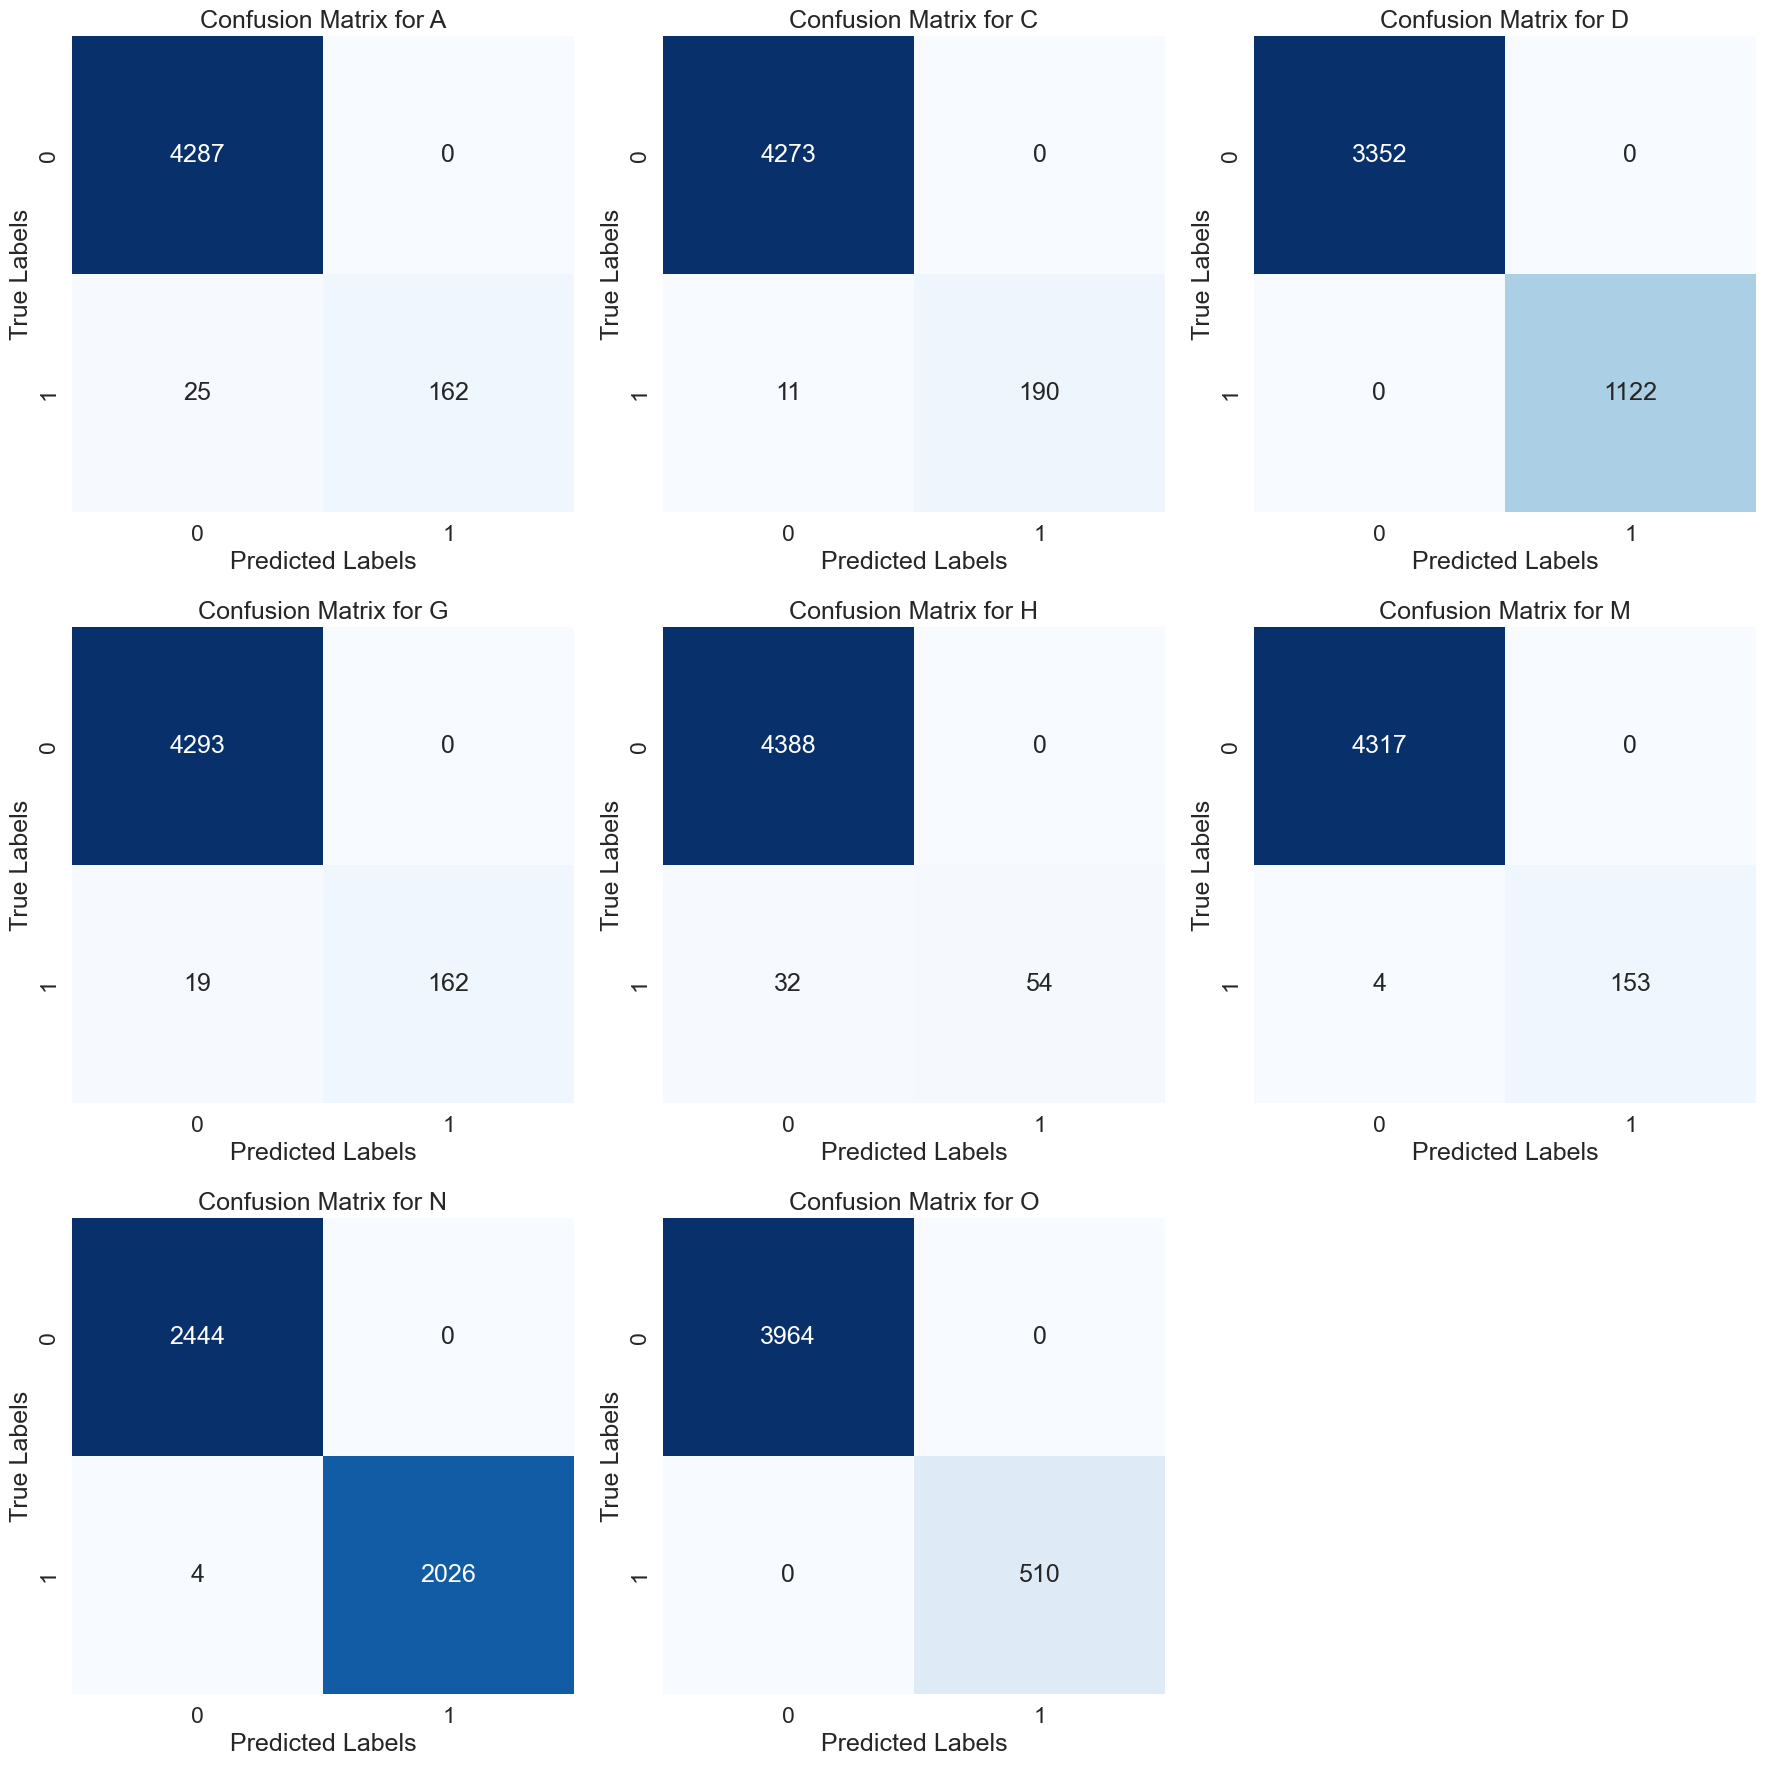

In [130]:
# sets up the random forest classifier train and validate instance
# to tweak you can add n_estimators and max_depth to changes the parameters of the Random Forest parameters
# you will tune at this level
rclf = RandomForestClassifier(n_estimators = 92, max_depth= 9, random_state=43)

# parameters
# x_train,y_train

train_the_model(rclf, x_train, y_train, name="Training Random Forest Classifier")

display_the_confsion_matrix(rclf, x_train, y_train)

Classification Report for Validating Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        38
           1       1.00      0.93      0.96        44
           2       1.00      1.00      1.00       255
           3       1.00      1.00      1.00        54
           4       1.00      0.87      0.93        23
           5       1.00      0.68      0.81        28
           6       1.00      1.00      1.00       416
           7       1.00      1.00      1.00       101

   micro avg       1.00      0.98      0.99       959
   macro avg       1.00      0.92      0.95       959
weighted avg       1.00      0.98      0.99       959
 samples avg       1.00      0.98      0.98       959



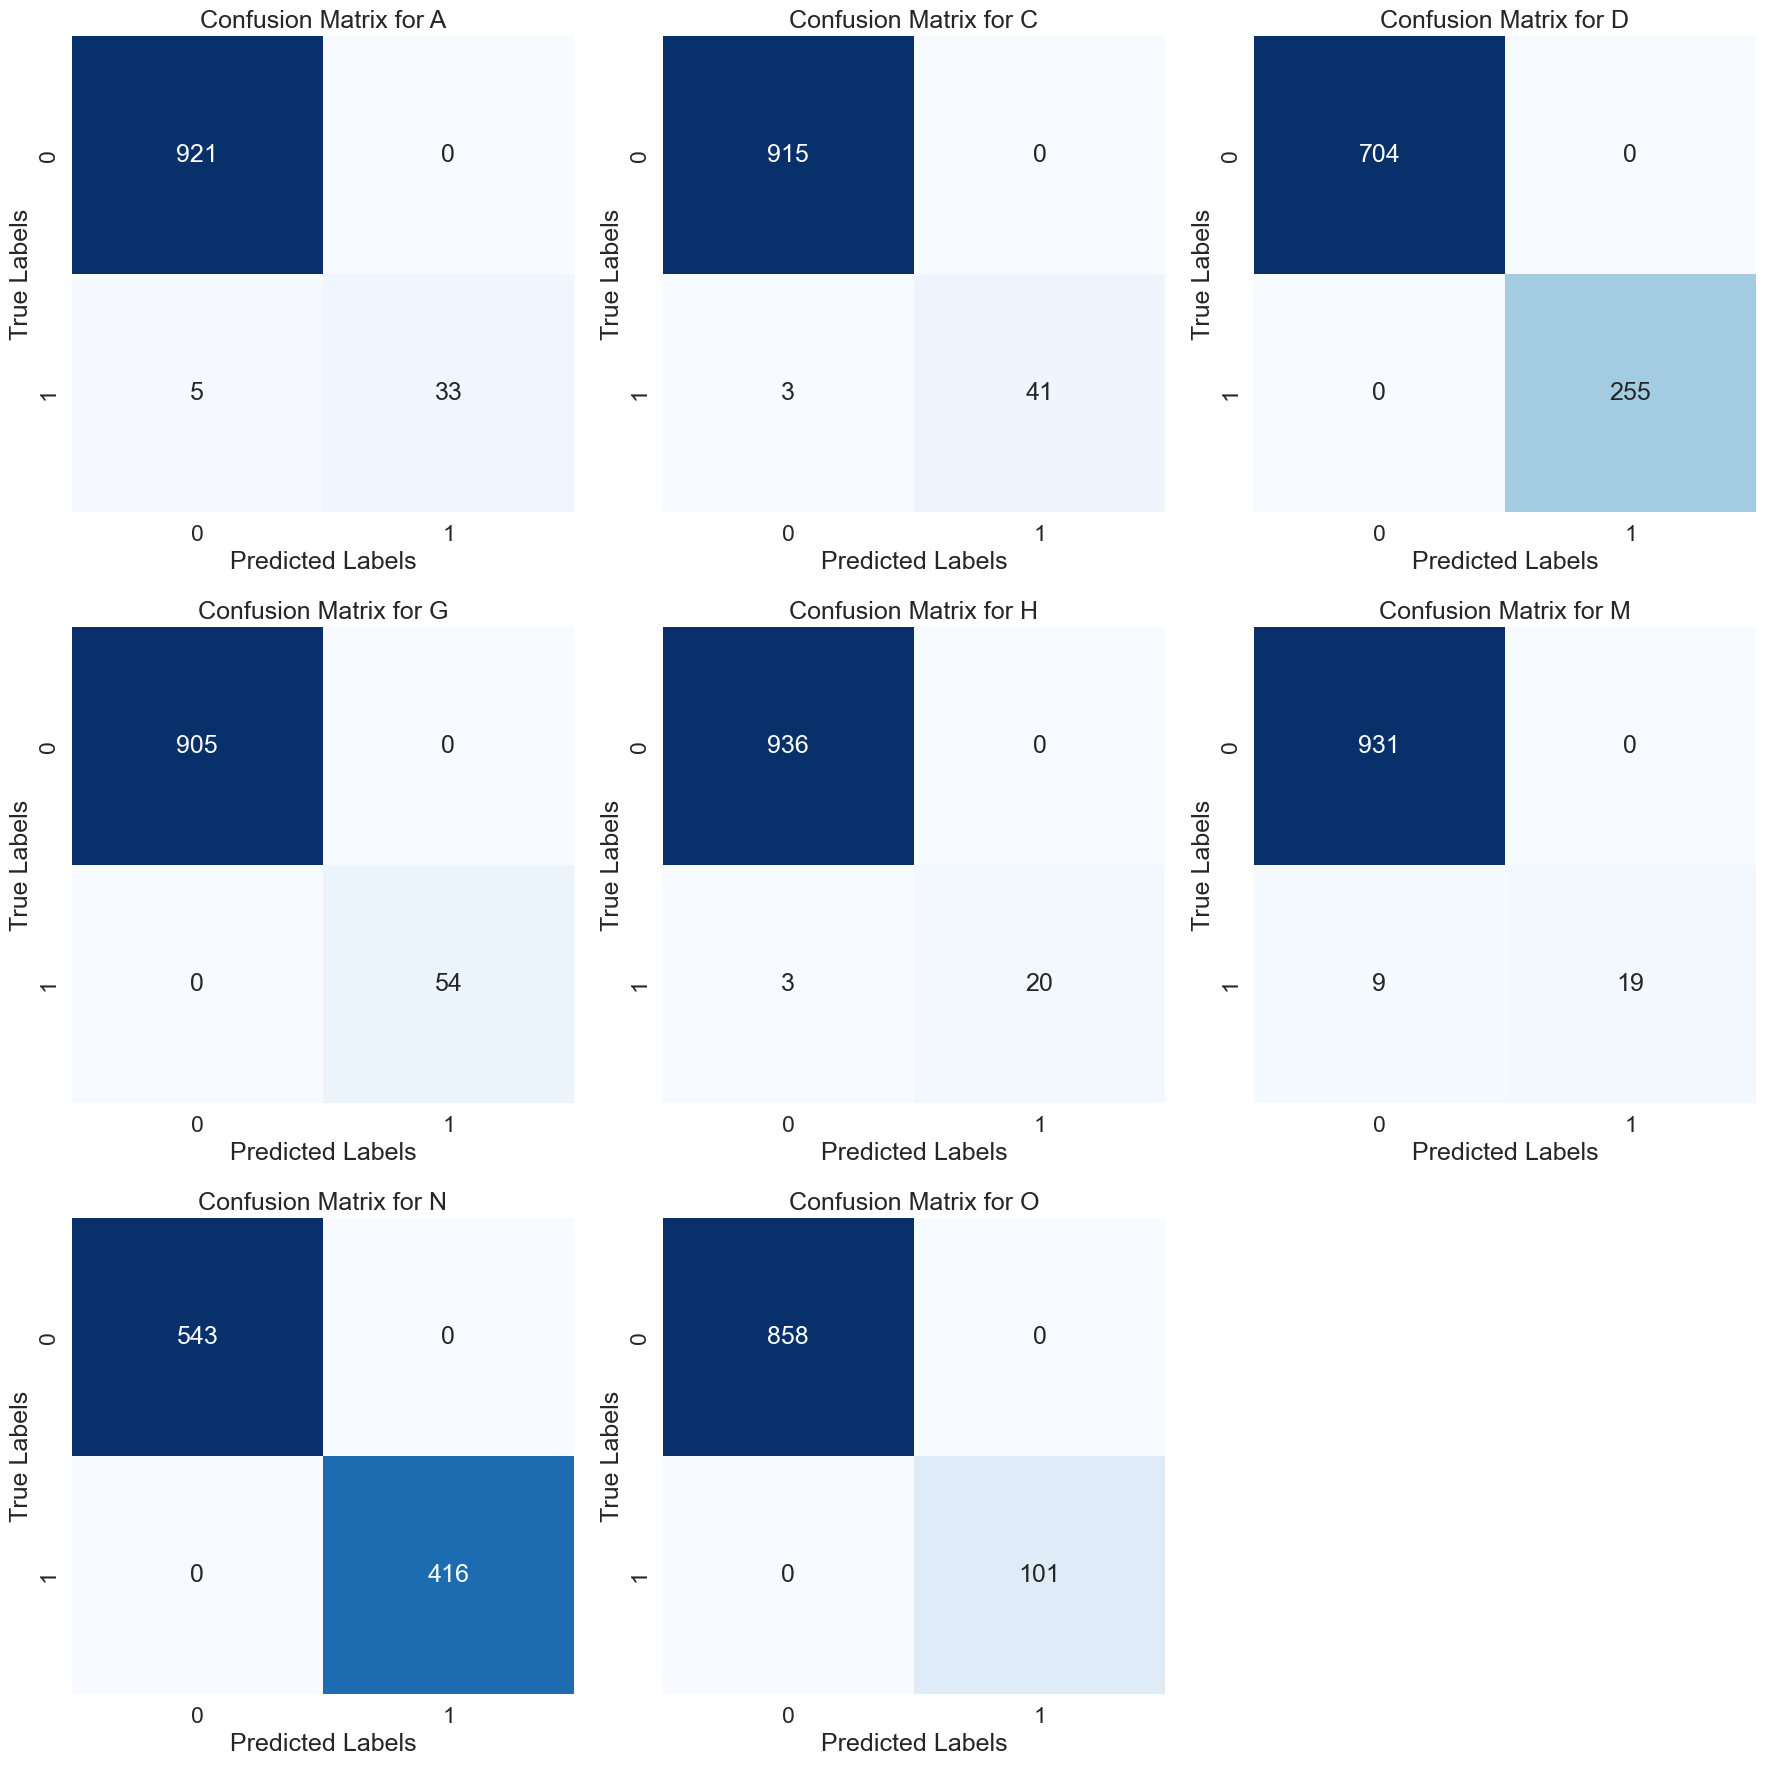

In [131]:
# parameters
# x_val,y_val

train_the_model(rclf, x_val,y_val, name="Validating Random Forest Classifier")

display_the_confsion_matrix(rclf, x_val,y_val)

Classification Report for Final testing of Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        41
           1       1.00      0.96      0.98        48
           2       1.00      1.00      1.00       231
           3       1.00      0.90      0.95        49
           4       1.00      0.84      0.91        19
           5       1.00      0.98      0.99        47
           6       1.00      1.00      1.00       427
           7       1.00      1.00      1.00        97

   micro avg       1.00      0.99      0.99       959
   macro avg       1.00      0.95      0.97       959
weighted avg       1.00      0.99      0.99       959
 samples avg       1.00      0.99      0.99       959



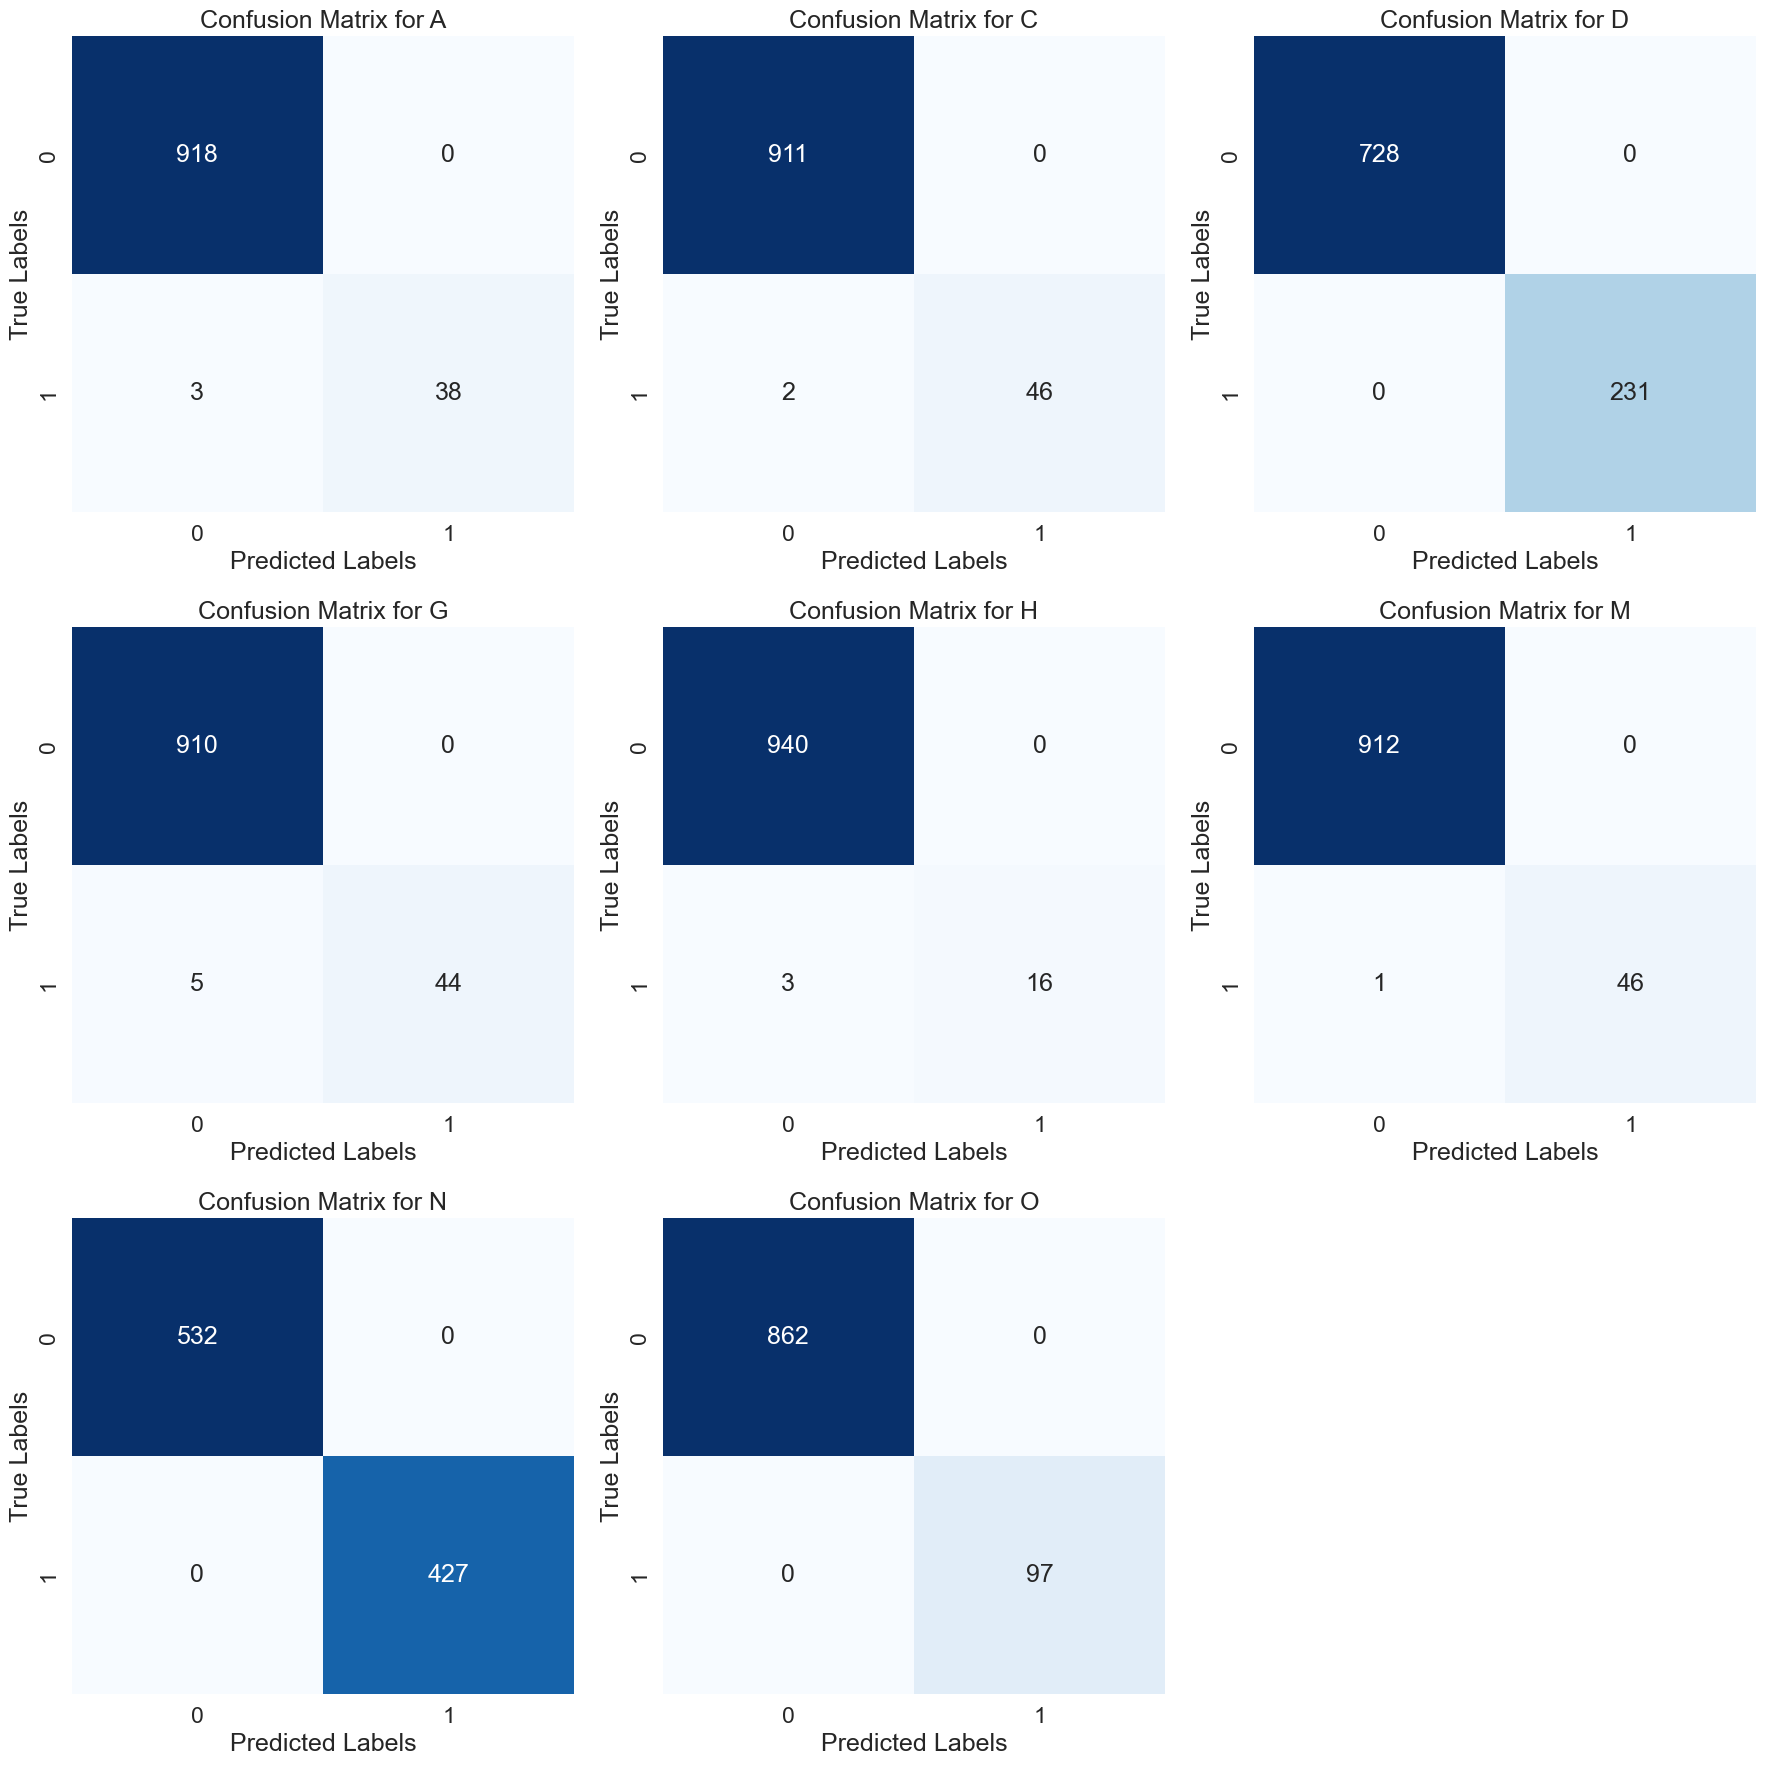

In [132]:
# hold set (final testing set)

# parameters
# x_hold,y_hold

train_the_model(rclf, x_hold,y_hold, name="Final testing of Random Forest Classifier")

display_the_confsion_matrix(rclf, x_hold,y_hold)